# Домашная работа II
Гусев Владислав, БЭК212

Для начала импортируем все необходимые библиотеки и отключим ненужные предупреждения:

In [1]:
import numpy as np
import pandas as pd

from scipy import stats 
from scipy.optimize import minimize

import seaborn as sns
import matplotlib.pyplot as plt

from math import factorial
from math import comb
from scipy.stats import t
from tqdm import tqdm
import itertools

import warnings
warnings.filterwarnings("ignore")

# Задача №1

## Пункт а)

Разложим функцию правдоподобия на 2 части:
(В нашем случае m = 10 заказам)
1. Первые 9 заказов - таксисты не повторяются (m-1)

$\sum_{i=1}^{m-2}$ (n-$k_{i}$)/n , где $k_{i}$ = 1,2...$\infty$

2. Последний заказ - вероятность получить таксиста (m), который уже был в предыдущих (m-1) заказах

(m-1)/n , где (m-1) таксистов уже приезжали, а n - сколько всего таксистов было

**Таким образом**, функция правдоподобия будет иметь следующий вид:

L = $\sum_{i=1}^{m - 2}$ (n - $k_{i}$)/n * (m - 1)/n => L = $\sum_{i=1}^{8}$ (n - $k_{i}$)/n * (9/n)

Запишем логарифимическую функцию правдоподобия:

lnL = ln(9) - 9ln(n) + $\sum_{i=1}^{8} t_i$ (n - $k_{i}$)

### 1. Построим график функции максимального правдоподобия

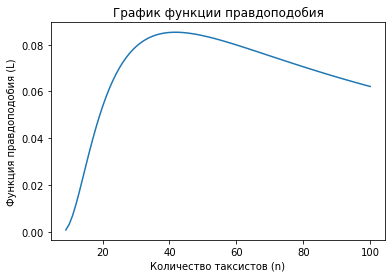

In [2]:
#Обычное правдоподобие
def likelihood(n_list):
    listik = []
    for n in n_list:
        L = 1 # на первом заказе
        for m in range(1, 9):
            L *= (n - m)/n
        L *= (9/n)
        listik.append(L)
    return listik


n_values = np.arange(9, 101)

sns.lineplot(n_values, likelihood(n_values))
plt.xlabel('Количество таксистов (n)')
plt.ylabel('Функция правдоподобия (L)')
plt.title('График функции правдоподобия')
plt.show()

### 2. Рассчитаем оценку методом максимального правдоподобия

In [3]:
n_ml = n_values[np.where(np.array(likelihood(n_values)) == np.amax(np.array(likelihood(n_values))))[0][0]]
print("Максимального значения функция правдоподобия достигает в точке n = ",n_ml, "- это и есть оценка максимального правдоподобия")

Максимального значения функция правдоподобия достигает в точке n =  42 - это и есть оценка максимального правдоподобия


$\hat{n}_{ML}$ = 42

## Пункт б)

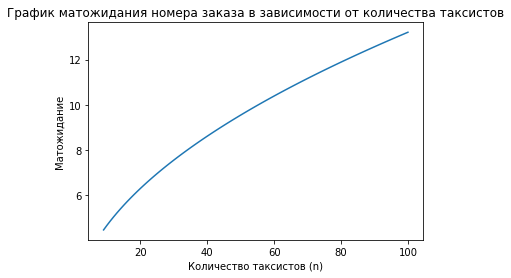

In [4]:
#m - номер заказа, на котором приедет повторяющийся таксист, а также m >= 2 и m <= n + 1

def matozhidaniye(n_list):
    listik = []
    for n in n_list:
        matozhid = 0
        for m in range(2, n+2):
            zakaz = 1
            for k in range(1, m-1):
                zakaz *= (n - k)/n
            zakaz *= (m-1)/n
            matozhid += zakaz * m
        listik.append(matozhid)
    return listik

n_values = np.arange(9, 101)

plt.plot(n_values, matozhidaniye(n_values))
plt.xlabel('Количество таксистов (n)')
plt.ylabel('Матожидание')
plt.title('График матожидания номера заказа в зависимости от количества таксистов')
plt.show()


Теоретическое матожидание: функция matozhidaniye, зависящая от n
Выборочное среднее: m = 10

In [5]:
np.where(matozhidaniye(n_values) == 10) #Придется найти максимально близкое значение

(array([], dtype=int64),)

In [6]:
listik = []
for i in matozhidaniye(n_values):
    x = np.sqrt((i - 10)**2)
    listik.append(x)
n_values[np.where(np.array(listik) == np.amin(np.array(listik)))[0][0]] #Получили оценку методом моментов

55

$\hat{n}_{MM}$ = 55

In [7]:
n_values[np.argmin(listik)]

55

## Пункт в)

In [8]:
np.random.seed(1337)
#генерируем m в 10000 экспериментах:
all_obs = []
taxi = np.arange(101)
for i in range(10**4): # эксперименты
    listik = []
    day = 1
    taxist = np.random.choice(taxi)
    while taxist not in listik: #возможные номера заказов, на которых получился повторяющийся таксист
        day += 1
        listik.append(taxist)
        taxist = np.random.choice(taxi)
    all_obs.append(day)

In [9]:
#генерируем ml оценки
ml = []
for i in tqdm(all_obs):
    listik = []
    n_values = np.arange(i-1, 500, 1)
    for n in n_values:
        L = 1 # на первом заказе
        for m in range(1, i-1):
            L *= (n - m)/n
        L *= ((i-1)/n)
        listik.append(L)
    n_ml = n_values[np.where(np.array(listik) == np.amax(np.array(listik)))[0][0]]
    ml.append(n_ml)

100%|██████████| 10000/10000 [00:28<00:00, 356.32it/s]


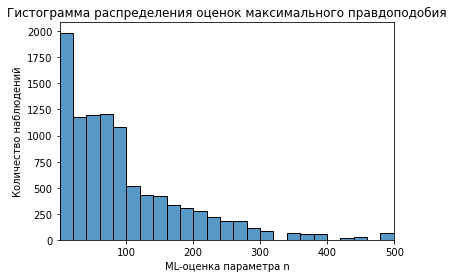

In [10]:
sns.histplot(ml, bins = 25)

plt.title("Гистограмма распределения оценок максимального правдоподобия")
plt.xlabel("ML-оценка параметра n")
plt.ylabel("Количество наблюдений")
plt.xlim(1,500)
None

In [11]:
print("Смещение:", np.mean(np.array(ml)) - 100)
print("Дисперсия:", np.array(ml).var(ddof = 1))
print("MSE:", ((np.array(ml) - 100)**2).sum()/10000)

Смещение: -4.388900000000007
Дисперсия: 8272.499506740674
MSE: 8290.9347


In [12]:
mm = []
every = np.array([])
for i in tqdm(all_obs[1:11]): #Код работающий, однако крайне медленный, поэтому визуализировать все 10**4 экспериментов не получится
    listik = []
    n_values = np.arange(i-1, 1001, 1)
    oshibki =[]
    for n in n_values:
        matozhid = 0
        for m in range(2, n+2):
            zakaz = 1
            for k in range(1, m-1):
                zakaz *= (n - k)/n
            zakaz *= (m-1)/n
            matozhid += zakaz * m
        oshibka = abs(matozhid - i)
        oshibki.append(oshibka)
    n_mm = n_values[np.argmin(oshibki)]
    mm.append(n_mm)

100%|██████████| 10/10 [12:08<00:00, 72.89s/it]


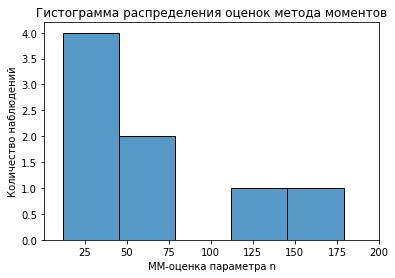

In [13]:
sns.histplot(mm, bins = 10)
plt.title("Гистограмма распределения оценок метода моментов")
plt.xlabel("MM-оценка параметра n")
plt.ylabel("Количество наблюдений")
plt.xlim(1,200)
None

In [14]:
print("Смещение:", np.mean(np.array(mm)) - 100)
print("Дисперсия:", np.array(mm).var(ddof = 1))
print("MSE:", ((np.array(mm) - 100)**2).sum()/10)

Смещение: 9.200000000000003
Дисперсия: 12253.28888888889
MSE: 11112.6


# Задача №2

## Пункт а)
Постройте график функции правдоподобия как функции от общего количества имён
n. Найдите оценку числа n методом максимального правдоподобия.

1. Вероятности на первых порах встретить уникальные имена (в нашем случае их (6-1) штук = m, т.к вероятность уникального имени при первом заказе = 1):
2. Вероятности на вторых порах встретить повторяющиеся имена (4 штуки = x - m, где x - общее количество имен/заказов)

$\Pi_{i=1}^{5}$ (n - i)/n * $(m/n)^{4}$

Однако все эти параметры могут быть расположены в любом порядке, что вызывает необходимость добавить коэффициент? который выбирает из имеющегося набора заказов начиная со второго (9 штук) заказы, к которых имена у таксистов повторялись (x-m = 4). Напишем для этого отдельную функцию:

In [15]:
def perebor(m, n, x: int = 10):
    
    prob = 1
    s = 0
    
    for i in range(1, m):
        prob *= ((n-i)/n)
    combo = itertools.combinations_with_replacement(np.arange(1, m+1), x - m)
    
    for el in combo:
        prob_repeat = 1
        for i in range(x-m):
            prob_repeat *= el[i]
        s += prob_repeat
        
    prob *= (s/(n**(x - m)))
    return prob 

### 1. Построим график функции максимального правдоподобия

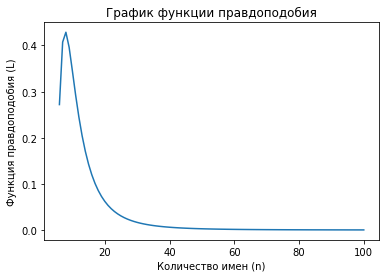

In [16]:
n_values = np.arange(6,101)
values = [perebor(6, n) for n in n_values]

plt.plot(n_values, values)
plt.xlabel('Количество имен (n)')
plt.ylabel('Функция правдоподобия (L)')
plt.title('График функции правдоподобия')
plt.show()

### 2. Рассчитаем оценку методом максимального правдоподобия

In [17]:
n_ml = n_values[np.argmax(values)]
print("Максимального значения функция правдоподобия достигает в точке n = ",n_ml, "- это и есть оценка максимального правдоподобия")

Максимального значения функция правдоподобия достигает в точке n =  8 - это и есть оценка максимального правдоподобия


$\hat{n}_{ML}$ = 8

## Пункт б)

Постройте график математического ожидания числа разных имён у 10 таксистов, как
функции от общего количества имён n. Найдите оценку числа n методом моментов

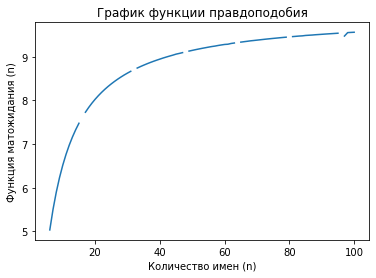

In [18]:
# Далее определим функцию для матожидания. Так как уже вероятности посчитаны, в функцию остается добавить последовательные
# значения для каждого заказа
x = 10
def expected(n):
    summa = 0
    for m in range(1, 11):
        summa += m*perebor(m,n)
    return summa

n_values = np.arange(6,101)
values = [expected(n) for n in n_values]

plt.plot(n_values, values)
plt.xlabel('Количество имен (n)')
plt.ylabel('Функция матожидания (n)')
plt.title('График функции правдоподобия')
plt.show()

In [19]:
#Найдем оценку метода моментов:
listik = []
for i in values:
    x = np.sqrt((i - 6)**2)
    listik.append(x)
n_values[np.argmin(listik)] #Получили оценку методом моментов

8

$\hat{n}_{MM}$ = 55

## Пункт в)

In [20]:
# Создадим 10^4 экспериментов:
true_n = 20
n = range(1,true_n+1)
listik = []
np.random.seed(1337)
for i in tqdm(range(10**4)): 
    taxist = np.random.choice(n,10)
    listik.append(len(set(taxist)))

100%|██████████| 10000/10000 [00:00<00:00, 38595.53it/s]


In [21]:
ml = []
for k in tqdm(listik):
    n_obs = np.arange(k, 150)
    okay = [perebor(k, n) for n in range(k, 150)]
    if n_obs[np.argmax(okay)] < 100:
        ml.append(n_obs[np.argmax(okay)])
    else:
        ml.append(100)

100%|██████████| 10000/10000 [00:40<00:00, 249.66it/s]


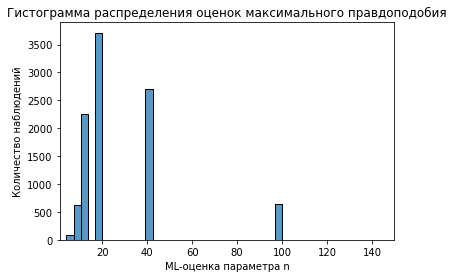

In [22]:
sns.histplot(ml, bins = 30)
plt.title("Гистограмма распределения оценок максимального правдоподобия")
plt.xlabel("ML-оценка параметра n")
plt.ylabel("Количество наблюдений")
plt.xlim(1,150)
None

In [23]:
print("Смещение:", np.mean(np.array(ml)) - true_n)
print("Дисперсия:", np.array(ml).var(ddof = 1))
print("MSE:", ((np.array(ml) - true_n)**2).sum()/10000)

Смещение: 7.966899999999999
Дисперсия: 498.08881327132724
MSE: 561.5105


In [24]:
mm = []
for k in tqdm(listik):
    ocenka = n_values[(abs(np.array(values) - k) == np.min(abs(np.array(values) - k)))][0]
    if ocenka < 100:
        mm.append(ocenka)
    else:
        mm.append(100)

100%|██████████| 10000/10000 [00:00<00:00, 46995.37it/s]


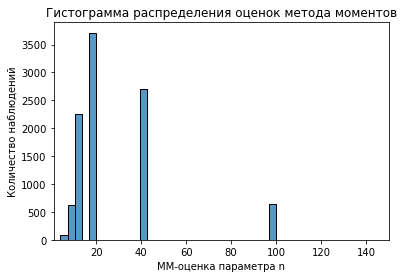

In [25]:
sns.histplot(ml, bins = 30)
plt.title("Гистограмма распределения оценок метода моментов")
plt.xlabel("MM-оценка параметра n")
plt.ylabel("Количество наблюдений")
plt.xlim(1,150)
None

In [26]:
print("Смещение:", np.mean(np.array(mm)) - true_n)
print("Дисперсия:", np.array(mm).var(ddof = 1))
print("MSE:", ((np.array(mm) - true_n)**2).sum()/10000)

Смещение: 8.3474
Дисперсия: 491.2376370037004
MSE: 560.8676


------------

# Задача №3

## Пункт а)

In [27]:
np.random.seed(1337)
# Обычный нормальный асимптотический интервал:
value = 0
for i in range(10000):
    x = np.random.exponential(scale = 1, size = 20)
    x_mean = np.mean(x)
    x_std = np.std(x)
    ci_d = x_mean - 1.96 * x_std/np.sqrt(len(x))
    ci_u = x_mean + 1.96 * x_std/np.sqrt(len(x))
    if (ci_d < 1) & (ci_u > 1):
        value +=1
print("Вероятность накрытия:", value/10000)

Вероятность накрытия: 0.8991


In [28]:
np.random.seed(1337)
#Наивный бутстрэп
value = 0
for i in tqdm(range(10000)):
    x = np.random.exponential(scale = 1, size = 20) #Истинный закон распределения
    x_boot = np.random.choice(x, (10000,20))
    x_boot_mean = np.mean(x_boot, axis = 1)
    q_l = np.quantile(x_boot_mean, 0.025)
    q_r = np.quantile(x_boot_mean, 0.975)
    if (q_l < 1) & (q_r > 1):
        value +=1
print("Вероятность накрытия:" , value/10000)

100%|██████████| 10000/10000 [00:39<00:00, 254.19it/s]

Вероятность накрытия: 0.9012


In [29]:
np.random.seed(1337)
#Бутстрэп t-статистики
value = 0
for i in tqdm(range(10000)):
    x = np.random.exponential(scale = 1, size = 20) #Истинный закон распределения
    x_mean = np.mean(x)
    x_std = np.std(x)
    x_boot = np.random.choice(x, (10000,20))
    x_boot_mean = np.mean(x_boot, axis = 1)
    x_std_boot = np.std(x_boot, axis =1)
    r = (x_boot_mean - x_mean) / x_std_boot
    q_l = x_mean - np.quantile(r, 0.025) * x_std
    q_r = x_mean - np.quantile(r, 0.975) * x_std
    if (q_l > 1) & (q_r < 1):
        value +=1
print("Вероятность накрытия:" , value/10000)

100%|██████████| 10000/10000 [00:49<00:00, 201.89it/s]

Вероятность накрытия: 0.945


## Пункт б)

In [30]:
np.random.seed(1337)
# Обычный нормальный асимптотический интервал:
value = 0
for i in range(10000):
    x = np.random.standard_t(df = 3, size = 20)
    x_mean = np.mean(x)
    x_std = np.std(x)
    ci_d = x_mean - 1.96 * x_std/np.sqrt(len(x))
    ci_u = x_mean + 1.96 * x_std/np.sqrt(len(x))
    if (ci_d < 0) & (ci_u > 0):
        value +=1
print("Вероятность накрытия:", value/10000)

Вероятность накрытия: 0.9363


In [31]:
np.random.seed(1337)
#Наивный бутстрэп
value = 0
for i in tqdm(range(10000)):
    x = np.random.standard_t(df = 3, size = 20) #Истинный закон распределения
    x_boot = np.random.choice(x, (10000,20))
    x_boot_mean = np.mean(x_boot, axis = 1)
    q_l = np.quantile(x_boot_mean, 0.025)
    q_r = np.quantile(x_boot_mean, 0.975)
    if (q_l < 0) & (q_r > 0):
        value +=1
print("Вероятность накрытия:" , value/10000)

100%|██████████| 10000/10000 [00:37<00:00, 265.09it/s]

Вероятность накрытия: 0.9159


In [32]:
np.random.seed(1337)
#Бутстрэп t-статистики
value = 0
for i in tqdm(range(10000)):
    x = np.random.standard_t(df = 3, size = 20) #Истинный закон распределения
    x_mean = np.mean(x)
    x_std = np.std(x)
    x_boot = np.random.choice(x, (10000,20))
    x_boot_mean = np.mean(x_boot, axis = 1)
    x_std_boot = np.std(x_boot, axis =1)
    r = (x_boot_mean - x_mean) / x_std_boot
    q_l = x_mean - np.quantile(r, 0.025) * x_std
    q_r = x_mean - np.quantile(r, 0.975) * x_std
    if (q_l > 0) & (q_r < 0):
        value +=1
print("Вероятность накрытия:" , value/10000)

100%|██████████| 10000/10000 [00:50<00:00, 199.91it/s]

Вероятность накрытия: 0.9211


## Пункт в)

Для экспоненциального распределения наивный бутстрап t-статистики оказался лучшими методами оценки матожидания с точки зрения вероятности накрытия этого значения 95% доверительным интервалом.

Для распределени Стьюдента лучший результат показал асимптотический нормальный интервал

# Задача №4

In [33]:
c = pd.read_excel('кабачки.xlsx')
glasnaya = ['А', 'Е', 'Ё', 'И', 'О', 'У', 'Ы', 'Э', 'Ю', 'Я']

c['Оценка'].replace('неявка', 0, inplace=True)
c['Оценка'].fillna(0, inplace = True)

c["Гласная"] = np.where(c["Фамилия"].str[0].isin(glasnaya), 1, 0)

print('Средняя оценка:', c['Оценка'].mean())
c.head()

Средняя оценка: 4.903614457831325


,Оценка,Фамилия,Балл,Гласная
0,4.0,Репенкова,16,0
1,0.0,Ролдугина,0,0
2,5.0,Сафина,19,0
3,9.0,Сидоров,26,0
4,6.0,Солоухин,21,0


## Пункт а)

In [34]:
x = c[c['Гласная'] == 1]['Оценка']
y = c[c['Гласная'] == 0]['Оценка']
x_std2 = np.std(x)**2
y_std2 = np.std(y)**2
nx = x.shape[0]
ny = y.shape[0]
se_xy = np.sqrt(x_std2/nx + y_std2/ny)

In [35]:
d = ((x_std2/nx + y_std2/ny)**2)/((x_std2**2)/((nx**2)*(nx-1)) + (y_std2**2)/((ny**2)*(ny-1)))
print(d)
# То есть берем t-распределение с 63 степенями свободы
q_l = t.interval(0.95, 63, loc=0, scale=1)[0]
q_r = t.interval(0.95, 63, loc=0, scale=1)[1]

62.96433541808047


In [36]:
ci_l = x.mean() - y.mean() + q_l * se_xy 
ci_r = x.mean() - y.mean() + q_r * se_xy 
print("Левая граница:", ci_l, "Правая граница:", ci_r)

Левая граница: -1.4911624184690813 Правая граница: 0.23292343382928882


**Вывод:** 95% доверительный интервал накрывает нулевое значение статистики, поэтому гипотеза о равенстве матожиданий результата экзамена не отвергается

## Пункт б)

-0.8548658686089275 0.8497962789356028


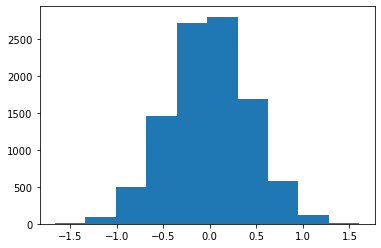

In [37]:
np.random.seed(1337)
#Наивный бутстрэп
x_mean = x.mean()
y_mean = y.mean()
r_list = []
for i in range(10000):
    x_boot = np.random.choice(x, nx)
    y_boot = np.random.choice(y, ny)
    
    x_boot_mean = np.mean(x_boot)
    y_boot_mean = np.mean(y_boot)
    
    r = (x_boot_mean - y_boot_mean) - (x_mean - y_mean)
    r_list.append(r)
q_l = np.quantile(r_list, 0.025)
q_r = np.quantile(r_list, 0.975)
print(q_l,q_r)
plt.hist(r_list)
None

In [38]:
ci_l = x_mean - y_mean - q_r
ci_d = x_mean - y_mean - q_l
print("Левая граница:", ci_l, "Правая граница:", ci_r)

Левая граница: -1.478915771255499 Правая граница: 0.23292343382928882


**Вывод:** 95% доверительный интервал накрывает нулевое значение статистики, поэтому гипотеза о равенстве матожиданий результата экзамена не отвергается

## Пункт в)

-1.5934849365590396 1.5719299398661748


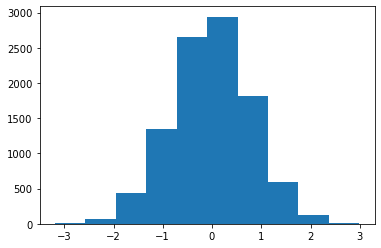

In [39]:
np.random.seed(1337)
#Бутстрэп t-статистики
x_mean = x.mean()
y_mean = y.mean()
x_se = np.std(x) / np.sqrt(nx)
y_se = x.std() / np.sqrt(ny)
r_list = []
for i in range(10000):
    x_boot = np.random.choice(x, nx)
    y_boot = np.random.choice(y, ny)
    
    x_boot_mean = np.mean(x_boot)
    y_boot_mean = np.mean(y_boot)
    
    x_se_boot = np.std(x_boot) / np.sqrt(nx)
    y_se_boot = np.std(y_boot) / np.sqrt(ny)
    
    se_xy_boot = np.sqrt((np.std(x_boot))**2/nx + (np.std(y_boot))**2/nx)
    
    r = (x_boot_mean - y_boot_mean -(x_mean - y_mean)) / se_xy_boot
    r_list.append(r)
q_l = np.quantile(r_list, 0.025)
q_r = np.quantile(r_list, 0.975)
print(q_l,q_r)
plt.hist(r_list)
None

In [40]:
ci_l = x_mean - y_mean - q_r * se_xy
ci_r = x_mean - y_mean - q_l * se_xy
print("Левая граница:", ci_l, "Правая граница:", ci_r)

Левая граница: -1.3072176726540783 Правая граница: 0.05827706936312993


**Вывод:** 95% доверительный интервал накрывает нулевое значение статистики, поэтому гипотеза о равенстве матожиданий результата экзамена не отвергается

## Пункт г)

In [41]:
# Перестановочный тест
c1 = pd.concat([c[c['Гласная'] == 1], c[c['Гласная'] == 0]], axis=0)
c1.drop(columns = ['Фамилия'], inplace = True)
c1

,Оценка,Балл,Гласная
17,8.0,25,1
18,10.0,26,1
32,8.0,25,1
45,10.0,29,1
46,8.0,26,1
...,...,...,...
326,1.0,4,0
327,5.0,19,0
328,0.0,0,0
329,0.0,0,0


100%|██████████| 1000/1000 [02:00<00:00,  8.32it/s]

-0.7967116175091951 0.8552679022138889


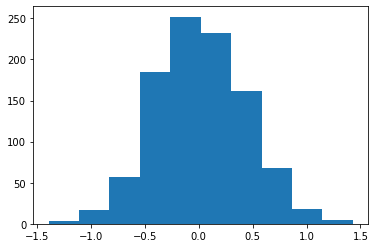

In [42]:
listik = []
for i in tqdm(range(10**3)):
    np.random.shuffle(c1['Гласная'])
    x_perest = c1[c1['Гласная'] == 1]['Оценка'].sum() / nx
    y_perest = c1[c1['Гласная'] == 0]['Оценка'].sum() / ny
    delta = x_perest - y_perest
    listik.append(delta)
q_l = np.quantile(listik, 0.025)
q_r = np.quantile(listik, 0.975)
print(q_l,q_r)
plt.hist(listik)
None

In [43]:
print("Значение статистики:", x_mean - y_mean)
print("Левая граница:", q_l, "Правая граница:", q_r)

Значение статистики: -0.6291194923198962
Левая граница: -0.7967116175091951 Правая граница: 0.8552679022138889


**Вывод**: 95% доверительный интервал накрывает нулевое значение статистики, поэтому гипотеза о равенстве матожиданий результата экзамена не отвергается

# Задача №5

In [47]:
с = pd.read_excel('кабачки.xlsx')
glasnaya = ['А', 'Е', 'Ё', 'И', 'О', 'У', 'Ы', 'Э', 'Ю', 'Я']

c['Оценка'].replace('неявка', 0, inplace=True)
c['Оценка'].fillna(0, inplace = True)

c["Гласная"] = np.where(c["Фамилия"].str[0].isin(glasnaya), 1, 0)
c["Хорош"] = np.where(c['Оценка'] > c['Оценка'].median(), 1, 0)

print('Есть гласная и оценка больше медианы:', с[(c["Гласная"] == 1) & (c["Хорош"] == 1)].shape[0])
print('Есть гласная и оценка меньше медианы:', с[(c["Гласная"] == 1) & (c["Хорош"] == 0)].shape[0])
print('Нет гласной и оценка больше медианы:', с[(c["Гласная"] == 0) & (c["Хорош"] == 1)].shape[0])
print('Нет гласной и оценка меньше медианы:', с[(c["Гласная"] == 0) & (c["Хорош"] == 0)].shape[0])

Есть гласная и оценка больше медианы: 18
Есть гласная и оценка меньше медианы: 31
Нет гласной и оценка больше медианы: 117
Нет гласной и оценка меньше медианы: 166


In [48]:
contingency = pd.DataFrame({'Плох': [31, 166], 'Хорош' : [18, 117]})
contingency.index = ['Есть гласная', 'Нет гласной']
contingency

,Плох,Хорош
Есть гласная,31,18
Нет гласной,166,117


## Пункт а)

In [49]:
# Отношение плохо написавших к хорошо написавшим:
# odds хорошо написать для гласной = 18 : 31
# odds хорошо написать для согласной = 117 : 166
OR_krishka = (18/31)/(117/166)
ln_OR = np.log(OR_krishka)
p_e = 18 / 31
p_c = 117/166
se = np.sqrt(1/31 + 1/18 + 1/166 + 1/117)

Учитывая, что каждый студент, выходя из экзаменационной аудитории понятия не имеет, как он написал работу, а тем более он не задумывается о том, на какую букву начинаются фамилии его одногруппников, то предположим, что ковариация между рисками хорошо написать для людей с начальной гласной и рисками хорошо написать для людей с начальной согласной равны 0 (двойное ослепление)

In [50]:
# Ди для Ln OR с крышкой:
ci_l = ln_OR - 1.96 * se
ci_r = ln_OR + 1.96 * se
print(ci_l, ci_r)

-0.8209548116110051 0.43335162555061657


In [51]:
# Ди для OR с крышкой:
ci_l = OR_krishka * np.exp(-1.96 * se)
ci_r = OR_krishka * np.exp(1.96 * se)
print(ci_l, ci_r)

0.44001132594764997 1.542418479106087


In [52]:
# H0: OR = 1 или H0: LnOR = 0
z_obs = (ln_OR - 0)/se
pval = 1 - stats.norm.cdf(z_obs)
print('Наблюдаемое значение:', z_obs, 'P-value:', pval)
# На уровне значимости 0.05 и при двусторонней гипотезе H0 не отвергается

Наблюдаемое значение: -0.6056751541493296 P-value: 0.7276347570768413


## Пункт б)

In [53]:
# Отношение плохо написавших к хорошо написавшим:
# вероятность хорошо написать для гласной = 18 / (18+31)
# вероятность хорошо написать для согласной = 117 / (117 + 166)
# OR(хорошо написать) = (18/11)/(177/166) = 1.5346
OR_krishka = (18/(18+31))/(117/(117+166))
ln_OR = np.log(OR_krishka)
p_e = 18 / (18+31)
p_c = 117/(117+166)
n_e = 18+31
n_c = 117 + 166
se = np.sqrt(1/(p_e * (1-p_e) * n_e) + 1/((p_c * (1-p_c) * n_c)))

In [54]:
# Ди для Ln OR с крышкой:
ci_l = ln_OR - 1.96 * se
ci_r = ln_OR + 1.96 * se
print(ci_l, ci_r)

-0.7453287959497912 0.5089776412118305


In [55]:
# H0: OR = 1 или H0: LnOR = 0
z_obs = (ln_OR - 0)/se
pval = 1 - stats.norm.cdf(z_obs)
print('Наблюдаемое значение:', z_obs, 'P-value:', pval)
# На уровне значимости 0.05 и при двусторонней гипотезе H0 не отвергается

Наблюдаемое значение: -0.36932622647994257 P-value: 0.6440577103361058


## Пункт в)

-0.3930529370116838 0.8584251889434721


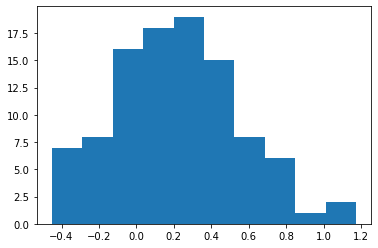

In [56]:
np.random.seed(1337)
c = pd.read_excel('кабачки.xlsx')
glasnaya = ['А', 'Е', 'Ё', 'И', 'О', 'У', 'Ы', 'Э', 'Ю', 'Я']

c['Оценка'].replace('неявка', 0, inplace=True)
c['Оценка'].fillna(0, inplace = True)
c["Гласная"] = np.where(c["Фамилия"].str[0].isin(glasnaya), 1, 0)
r_list = []

for i in range(10**2):
    c_boot = pd.DataFrame()
    c_boot['Гласная'] = np.random.choice(c['Гласная'], с.shape[0])
    c_boot['Оценка'] = np.random.choice(c['Оценка'], с.shape[0])

    c_boot["Хорош"] = np.where(c_boot['Оценка'] > c_boot['Оценка'].median(), 1, 0)

    a = c_boot[(c_boot['Гласная'] == 1) & (c_boot['Хорош'] == 1)].shape[0]
    b = c_boot[(c_boot["Гласная"] == 1) & (c_boot["Хорош"] == 0)].shape[0]
    cc = c_boot[(c_boot["Гласная"] == 0) & (c_boot["Хорош"] == 1)].shape[0]
    d = c_boot[(c_boot["Гласная"] == 0) & (c_boot["Хорош"] == 0)].shape[0]
    p_e = a / b
    p_c = cc / d
    OR_kr = p_e / p_c
    ln_OR = np.log(OR_kr)

    OR_krishka = (18/31)/(117/166)
    ln_OR_viborka = np.log(OR_krishka)

    r = ln_OR - ln_OR_viborka
    r_list.append(r)

q_l = np.quantile(r_list, 0.025)
q_r = np.quantile(r_list, 0.975)

print(q_l,q_r)
plt.hist(r_list)
None

In [57]:
ci_l = ln_OR_viborka - q_r
ci_r = ln_OR_viborka - q_l
print("Левая граница:", ci_l, "Правая граница:", ci_r)
#H0: OR = 1 или H0: lnOR = 0
#В данный 95% доверительный интервал значение 0 входит - именно поэтому гипотеза не отвергается

Левая граница: -1.0522267819736664 Правая граница: 0.1992513439814895


In [58]:
#Вероятность того, что данный интервал накрывает истинный интервал случайной величины lnOR равен:
p_value = (1 - stats.norm.cdf(abs(ci_l))) + stats.norm.cdf(abs(ci_r))
print("P-value:", p_value)

P-value: 0.7253146884458097


# Задача №6

In [59]:
c = pd.read_excel('кабачки.xlsx')

c['Длина'] = c['Фамилия'].str.len()

c.head()

,Оценка,Фамилия,Балл,Длина
0,4,Репенкова,16,9
1,неявка,Ролдугина,0,9
2,5,Сафина,19,6
3,9,Сидоров,26,7
4,6,Солоухин,21,8


## Пункт а)

Знаем, что E(Yi) = B * Xi;
Проматожидаем обе части: E(Yi) = B * E(Xi)
Для оценки методом моментов необходимо приравнять теоретическое матожидание к выборочному среднему, поэтому заменим их в форуме:
Yср = B * Xср - а вот эти две величины нам уже известны. Выражем B и считаем:

In [60]:
B = c['Балл'].mean() / c['Длина'].mean()
corel = c[['Балл', 'Длина']].corr().iloc[1,0]
print("Оценка параметра B методом моментов:", B, "Коэффициент выборочной корреляции Пирсона:", corel)

Оценка параметра B методом моментов: 2.0613026819923372 Коэффициент выборочной корреляции Пирсона: 0.025328052669147543


## Пункт б)

100%|██████████| 1000/1000 [02:12<00:00,  7.56it/s]


-0.10192548071700598 0.09894422173303753


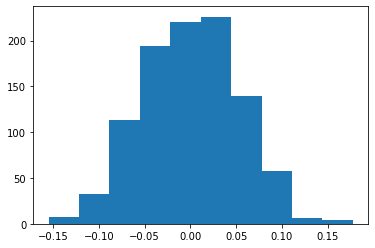

In [61]:
np.random.seed(1337)
listik = []
for i in tqdm(range(10**3)):
    np.random.shuffle(c['Балл'])
    corel = c[['Балл', 'Длина']].corr().iloc[1,0]
    listik.append(corel)
q_l = np.quantile(listik, 0.025)
q_r = np.quantile(listik, 0.975)
print(q_l,q_r)
plt.hist(listik)
None

**Вывод:** Выборочный коэффициент корреляции входит в границы построенного доверительного интервала (q_l;q_r) и именно поэтому гипотеза о равенстве истинной корреляции 0 не отвергается

# Задача №7

**Условие:** Учебная часть утверждает, что все три факультатива «Вязание крючком для экономистов», «Экономика
вышивания крестиком» и «Статистические методы в макраме» одинаково популярны. В этом году на
эти факультативы соответственно записалось 35, 31 и 40 человек. Правдоподобно ли заявление учебной
части? (КР№4 2009-2010 г.)

**Кого использовал:** ChatGPT & MJ | Telegram bot

#### Его итоговое решение:

Хорошо, пересчитаем статистику критерия согласия Пирсона с новыми наблюдаемыми частотами:
$$f_1 = 35,\quad f_2 = 31,\quad f_3 = 40$$

Вычислим ожидаемые частоты:
$$p_i = \frac{1}{3} = 0.333,\quad i = 1,2,3$$

Вычислим статистику критерия согласия Пирсона:
$$\chi^2 = \frac{(35-30\cdot0.333)^2}{30\cdot0.333} + \frac{(31-30\cdot0.333)^2}{30\cdot0.333} + \frac{(40-30\cdot0.333)^2}{30\cdot0.333} \approx 1.45$$

Для уровня значимости $\alpha = 0.05$ и количества степеней свободы $df = k-1 = 2$ критическое значение статистики критерия согласия Пирсона равно $5.99$.

Так как $\chi^2 < 5.99$, то гипотеза о равномерном распределении количества записавшихся на каждый из факультативов не отвергается, и можно сделать вывод о том, что заявление учебной части верно.

#### Сам диалог:

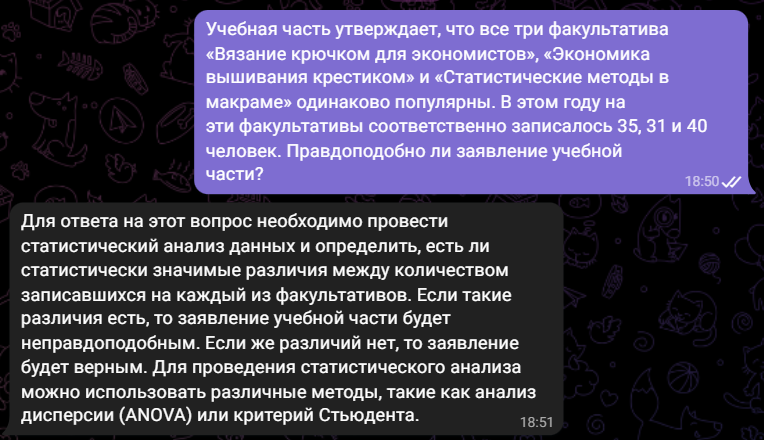

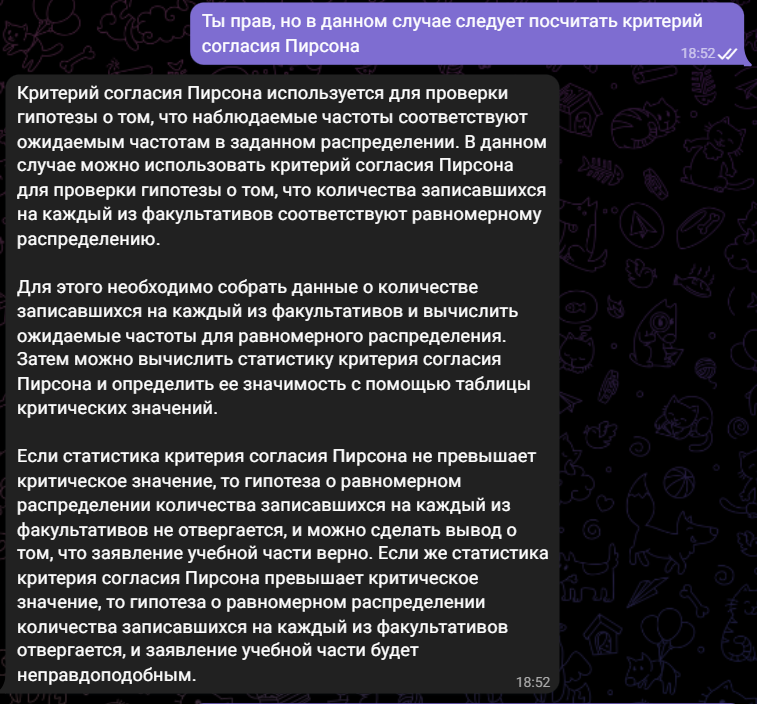

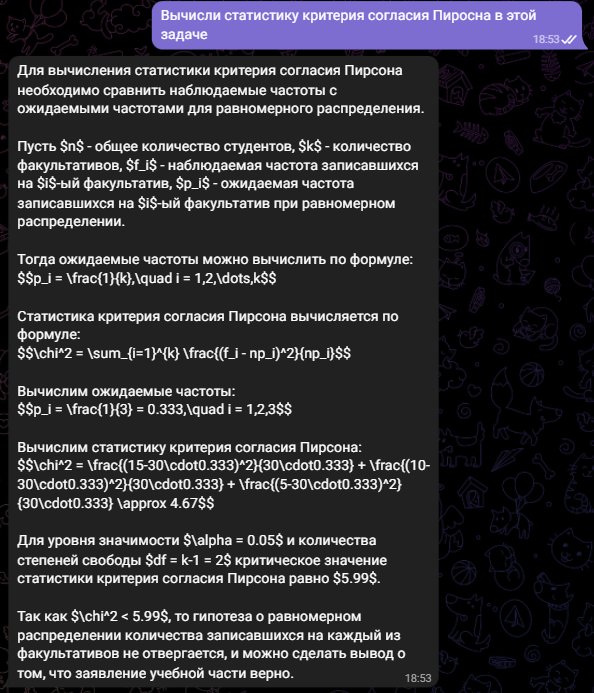

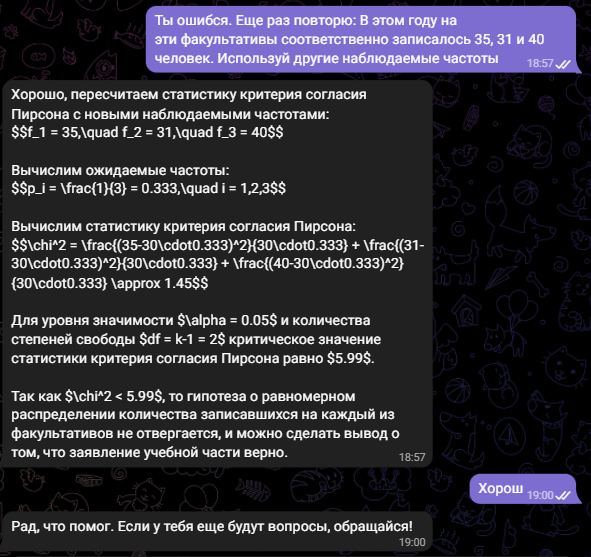

# Задача №8

### В целом для понимания матстата мне помогло два основных источника:
1. **Курс по подготовке к Независимому Экзамену по анализу данных**, он представлен в виде раздела "Статистика для анализа данных" в SmartLMS. В нем представлено огромное количество простых примеров на проверку гипотез, понятно объяснены все виды статистик (нормальное, Стьюдент, Хи-квадрат). В остальном он, конечно, проигрывает
2. **Записи видео курса Анализ данных на Python**, а именно семинары Максима: https://www.youtube.com/watch?v=rAzUonLG9Nc&list=PLunx6K2puwspZwACzSZvBcpenT4U8q6OY. Качественная структура, подробное объяснение на человеческом языке (не на математическо-формульном) всех тем из лекций основного курса по статистике. После этого семинара я понял, в чем смысл проверки гиптотез, что такое ошибки I и II рода, какие существуют методы их оценки. Интерпретация p-value на примерах и большое количество разобранных задач также помогли. Более того, механика LR-теста также была хорошо объяснена на примерах и стала в разы более понятна мне. Кроме того, данных курс помог мне упросить максимизацию правдоподобия, так как теперь я умею писать удобные функции на питончике.